In [28]:
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import price_data as price
import statistics
import time
from datetime import date,datetime
import os
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import chart

# Select your transport with a defined url endpoint
transport = AIOHTTPTransport(url="https://saturn.hasura.app/v1/graphql", headers={'x-hasura-admin-secret': 'Rc07SJt4ryC6RyNXDKFRAtFmRkGBbT8Ez3SdaEYsHQoHemCldvs52Kc803oK8X62'})

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

async def get_stored_data(symbol,timeframe):
    # Provide a GraphQL query
    split_symbol=symbol.split('/')
    base_currency=split_symbol[0]
    quote_currency=split_symbol[1]
    table=base_currency+quote_currency+'_'+timeframe
    if table=='BTCUSD_1d':
        query = gql(
            """
            query MyQuery {
                BTCUSD_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    elif table=='ETHUSD_1d':
        query = gql(
            """
            query MyQuery {
                ETHUSD_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    elif table=='ETHBTC_1d':
        query = gql(
            """
            query MyQuery {
                ETHBTC_1d {
                    unix
                    close
                    high
                    low
                    open
                }
            }
        """
        )
    else:
        return 'no such table'

    # Execute the query on the transport
    result = await client.execute_async(query)
    candles=result[table]
    df=pd.DataFrame({},columns=['unix','close','high','low','open'])
    for candle in candles:
        df=df.append(candle,ignore_index=True)

    return df.sort_values(by=['unix'], ignore_index=True)

    return result

def find_start(timestamps):
    start_found=False
    timestamps=list(map(lambda x:x[0]/1000,timestamps))
    index=len(timestamps)-1
    while not(start_found):
        print(timestamps[index])
        day=date.fromtimestamp(timestamps[index]).weekday()
        if day==0:
            start_found=True
        else:   
            index=index-1
    return index

def read_data(filename):
    raw=pd.read_csv('data/'+filename)
    timestamps=raw['unix']
    for i in range(len(timestamps)):
        if np.log10(timestamps.iloc[i])<12:
            raw.loc[i,'unix']=timestamps[i]*1000
    return raw.sort_values(by=['unix'], ignore_index=True)


In [29]:
btc_price_data= await get_stored_data('BTC/USD','1d')
btc_price_data
weekly_candles=price.get_price_data('1w',data=btc_price_data)
weekly_candles

,unix,open,high,low,close
0,1.423958e+12,224.22,266.84,214.00,234.14
1,1.424563e+12,234.14,248.98,228.62,236.59
2,1.425168e+12,236.59,265.00,232.61,261.15
3,1.425773e+12,262.47,294.00,259.60,275.23
4,1.426378e+12,275.23,303.96,275.01,286.12
...,...,...,...,...,...
340,1.629590e+12,47023.00,49788.00,43992.00,49266.00
341,1.630195e+12,49267.00,50558.00,46310.00,48800.00
342,1.630800e+12,48801.00,51928.00,46521.00,51807.00
343,1.631405e+12,51807.00,52961.00,42923.00,46024.00


In [30]:
month_dictionary={
    'Jan':1,
    'Feb':2,
    'Mar':3,
    'Apr':4,
    'May':5,
    'Jun':6,
    'Jul':7,
    'Aug':8,
    'Sep':9,
    'Oct':10,
    'Nov':11,
    'Dec':12,
}

def parse_data(datestring):
    string=datestring.split('-')
    month=month_dictionary[string[0]]
    day=int(string[1])
    year=int(string[2])
    d=date(year,month,day)

    return int(time.mktime(d.timetuple()))
    


In [31]:
def process_coincodex_csv(filename):

    raw_data=pd.read_csv('data/'+filename)
    vectorised_parsing=np.vectorize(parse_data)
    timestamps=vectorised_parsing(raw_data['Date'].values)
    df=raw_data

    df['unix']=timestamps
    df.columns = ['date','open','high','low','close','volume','market cap','unix']
    df.sort_values(by='unix', ignore_index=True, inplace=True)
    df.to_csv('data/'+filename+'_updated')

    return df

In [32]:
def find_intercepts(fast,slow): #each line is a dataframe with time stamp and value, assuming both have same length
    #starting state
    min_timestamp=max(fast['unix'].min(),slow['unix'].min())

    fast=fast.loc[fast['unix']>=min_timestamp]
    slow=slow.loc[slow['unix']>=min_timestamp]

    if len(fast) != len(slow):
        f=interp1d(slow['unix'],slow['value'])
        slow_interpolated=f(fast['unix'])
        slow=pd.DataFrame({'unix':fast['unix'],'value':slow_interpolated})

    timestamps=fast['unix'].values
    line1=fast['value'].values
    line2=slow['value'].values

    line1_above_line2=line1[0]>line2[0] #state
    cross_above=[]
    cross_below=[]
    for i in range(len(line1)):
        if line1_above_line2 and line1[i]<line2[i]:
            cross_below.append(timestamps[i])
        elif not(line1_above_line2) and line1[i]>line2[i]:
            cross_above.append(timestamps[i])
        
        line1_above_line2 = line1[i]>line2[i]

    return {'cross_above': cross_above,'cross_below': cross_below }

In [33]:
eth=await get_stored_data('ETH/USD','1d')

In [42]:
def sl_trigger(state, previous, current_eth_open_price):
    if state=='long' and current_price>previous:
        return True
    elif state=='short' and current_price<previous:
        return True
    else:
        return False

def price_hit(candle,price):
    return candle['high']>price and candle['low']<price

def backtest_ma_channel_small_gradient(data,period, h_l_period, ema_period):
    equity=1
    fee_rate=0.0006
    channel=chart.ma_channel(data,period)
    ema=chart.get_ema(data,ema_period)
    gradient=chart.get_gradient(ema)
    h_l_channel=chart.h_l_channel(data,h_l_period, False)
    start=channel['unix'].min()
    trimmed_data=data.loc[data['unix']>=start]
    trimmed_data=trimmed_data.loc[trimmed_data['unix']>= gradient.index.values.min()]
    channel=channel.loc[channel['unix']>= gradient.index.values.min()]
    state='neutral'
    equity_record=[]
    longs=[]
    shorts=[]
    outcome=[]
    profit=[]
    # day_long=[]
    # day_short=[]
    sl=None
    entry=None
    print('Trimmed datapoints: ',len(trimmed_data))
    for i in range(1,len(trimmed_data)):

        time=trimmed_data.iloc[i]['unix'].item()
        
        current_gradient=gradient.loc[time]
        five_opens=trimmed_data.loc[data['unix']<=time].iloc[-5:]['open'].values # uses opens now as opens are confirmed
        five_channel=channel.loc[channel['unix']<=time].iloc[-5:]
        channel_highs=five_channel['high']
        channel_lows=five_channel['low']
        current=five_opens[-1]
        previous_candle=trimmed_data.iloc[i-1]
        uptrend=current_gradient.item()>0
        # sl_channel_high=h_l_channel.loc[h_l_channel['unix']==time]['high'].item()
        # sl_channel_low=h_l_channel.loc[h_l_channel['unix']==time]['low'].item()

        # if sl!=None:
        #     if price_hit(previous_candle,sl):
        #         print('sl_hit')
        #         state='neutral'
        #         outcome.append(True)
        #         sl=None


        # if state=='long' and sl==None:
        #     if all(five_opens>entry):
        #         print('Setting sl')
        #         sl=np.mean([current, entry])

        # elif state=='short' and sl==None:
        #     if all(five_opens<entry):
        #         print('Setting sl')
        #         sl=np.mean([current, entry])

        
        if (five_opens>channel_highs).all() and state != 'long' and uptrend:
            #remember to calculate profit if flipping from short
            if state=='short':
                outcome.append(current<entry)
                profit.append(1-(current/entry))
                equity=equity*(1+(1-(current/entry))-fee_rate)
                # equity=(entry*trade_amount-current*trade_amount)+equity
            state='long'
            entry=current
            longs.append(time)
            # day_long.append((day,gradient.item()))
        elif (five_opens<channel_lows).all() and state != 'short' and not(uptrend):
            if state=='long':
                outcome.append(current>entry)
                profit.append(current/entry -1)
                equity=equity*(1+(current/entry -1)-fee_rate)
            entry=current
            # trade_amount=equity*entry
            state='short'
            shorts.append(time)
            # day_short.append((day,gradient.item()))
            #print(state+' from $'+str(current))
        if equity < 0:
            equity=0
            print('went broke')
            break

        if i==len(trimmed_data)-1:
            if state=='long':
                equity=equity*(current/entry)
            elif state=='short':
                equity=equity*(2-current/entry)

    
    return longs,shorts,np.array(outcome), np.array(profit), equity, day_long, day_short

def backtest_ma_channel(data,period, h_l_period, slow_ma_gradient):
    equity=1
    fee_rate=0.0006
    channel=chart.ma_channel(data,period)
    h_l_channel=chart.h_l_channel(data,h_l_period, False)
    start=channel['unix'].min()
    trimmed_data=data.loc[data['unix']>=start]
    trimmed_data=trimmed_data.loc[trimmed_data['unix']>= slow_ma_gradient.index.values.min()]
    channel=channel.loc[channel['unix']>= slow_ma_gradient.index.values.min()]
    state='neutral'
    equity_record=[]
    longs=[]
    shorts=[]
    outcome=[]
    profit=[]
    day_long=[]
    day_short=[]
    sl=None
    entry=None
    print('Trimmed datapoints: ',len(trimmed_data))
    for i in range(1,len(trimmed_data)):

        time=trimmed_data.iloc[i]['unix'].item()
        
        day=max(list(filter(lambda x: x <= time, slow_ma_gradient.index.values)))
        gradient=slow_ma_gradient.loc[day]
        five_opens=trimmed_data.loc[data['unix']<=time].iloc[-5:]['open'].values # uses opens now as opens are confirmed
        five_channel=channel.loc[channel['unix']<=time].iloc[-5:]
        channel_highs=five_channel['high']
        channel_lows=five_channel['low']
        current=five_opens[-1]
        previous_candle=trimmed_data.iloc[i-1]
        uptrend=gradient.item()>0
        # sl_channel_high=h_l_channel.loc[h_l_channel['unix']==time]['high'].item()
        # sl_channel_low=h_l_channel.loc[h_l_channel['unix']==time]['low'].item()

        # if sl!=None:
        #     if price_hit(previous_candle,sl):
        #         print('sl_hit')
        #         state='neutral'
        #         outcome.append(True)
        #         sl=None


        # if state=='long' and sl==None:
        #     if all(five_opens>entry):
        #         print('Setting sl')
        #         sl=np.mean([current, entry])

        # elif state=='short' and sl==None:
        #     if all(five_opens<entry):
        #         print('Setting sl')
        #         sl=np.mean([current, entry])

        
        if (five_opens>channel_highs).all() and state != 'long' and uptrend:
            #remember to calculate profit if flipping from short
            if state=='short':
                outcome.append(current<entry)
                profit.append(1-(current/entry))
                equity=equity*(1+(1-(current/entry))-fee_rate)
                # equity=(entry*trade_amount-current*trade_amount)+equity
            state='long'
            entry=current
            longs.append(time)
            day_long.append((day,gradient.item()))
        elif (five_opens<channel_lows).all() and state != 'short' and not(uptrend):
            if state=='long':
                outcome.append(current>entry)
                profit.append(current/entry -1)
                equity=equity*(1+(current/entry -1)-fee_rate)
            entry=current
            # trade_amount=equity*entry
            state='short'
            shorts.append(time)
            day_short.append((day,gradient.item()))
            #print(state+' from $'+str(current))
        if equity < 0:
            equity=0
            print('went broke')
            break

        if i==len(trimmed_data)-1:
            if state=='long':
                equity=equity*(current/entry)
            elif state=='short':
                equity=equity*(2-current/entry)

    
    return longs,shorts,np.array(outcome), np.array(profit), equity, day_long, day_short#pd.DataFrame({'unix':channel['unix'],'equity':equity_record})

def backtest_ma_channel_old(data,period, h_l_period, slow_ma_gradient):
    equity=1
    fee_rate=0.0006
    channel=chart.ma_channel(data,period)
    h_l_channel=chart.h_l_channel(data,h_l_period, False)
    start=channel['unix'].min()
    trimmed_data=data.loc[data['unix']>=start]
    trimmed_data=trimmed_data.loc[trimmed_data['unix']>= slow_ma_gradient.index.values.min()]
    channel=channel.loc[channel['unix']>= slow_ma_gradient.index.values.min()]
    state='neutral'
    equity_record=[]
    longs=[]
    shorts=[]
    outcome=[]
    profit=[]
    day_long=[]
    day_short=[]
    sl=None
    entry=None
    print('Trimmed datapoints: ',len(trimmed_data))
    for i in range(1,len(trimmed_data)):

        time=trimmed_data.iloc[i]['unix'].item()
        
        day=max(list(filter(lambda x: x <= time, slow_ma_gradient.index.values)))
        gradient=slow_ma_gradient.loc[day]
        five_opens=trimmed_data.loc[data['unix']<=time].iloc[-5:]['open'].values # uses opens now as opens are confirmed
        channel=channel.loc[channel['unix']==time]
        channel_high=channel['high']
        channel_low=channel['low']
        print(channel_high)
        current=five_opens[-1]
        previous_candle=trimmed_data.iloc[i-1]
        uptrend=gradient.item()>0
        # sl_channel_high=h_l_channel.loc[h_l_channel['unix']==time]['high'].item()
        # sl_channel_low=h_l_channel.loc[h_l_channel['unix']==time]['low'].item()

        # if sl!=None:
        #     if price_hit(previous_candle,sl):
        #         print('sl_hit')
        #         state='neutral'
        #         outcome.append(True)
        #         sl=None


        # if state=='long' and sl==None:
        #     if all(five_opens>entry):
        #         print('Setting sl')
        #         sl=np.mean([current, entry])

        # elif state=='short' and sl==None:
        #     if all(five_opens<entry):
        #         print('Setting sl')
        #         sl=np.mean([current, entry])

        
        if all(channel_high<open_price for open_price in five_opens) and state != 'long' and uptrend:
            #remember to calculate profit if flipping from short
            if state=='short':
                outcome.append(current<entry)
                profit.append(1-(current/entry))
                equity=equity*(1+(1-(current/entry))-fee_rate)
                # equity=(entry*trade_amount-current*trade_amount)+equity
            state='long'
            entry=current
            longs.append(time)
            day_long.append((day,gradient.item()))
        elif all(channel_high>open_price for open_price in five_opens) and state != 'short' and not(uptrend):
            if state=='long':
                outcome.append(current>entry)
                profit.append(current/entry -1)
                equity=equity*(1+(current/entry -1)-fee_rate)
            entry=current
            # trade_amount=equity*entry
            state='short'
            shorts.append(time)
            day_short.append((day,gradient.item()))
            #print(state+' from $'+str(current))
        if equity < 0:
            equity=0
            print('went broke')
            break

        if i==len(trimmed_data)-1:
            if state=='long':
                equity=equity*(current/entry)
            elif state=='short':
                equity=equity*(2-current/entry)

    
    return longs,shorts,np.array(outcome), np.array(profit), equity, day_long, day_short

def backtest_ma_channel_single_timeframe(data, data_btc,period,btc_ma_period, no_closes):
    equity=1
    fee_rate=0.0006
    weekly_btc=price.get_price_data('1w',data=data_btc)
    btc_ma=chart.get_sma(weekly_btc,btc_ma_period)
    channel=chart.ma_channel(data,period)
    start=channel['unix'].min()
    trimmed_data=data.loc[data['unix']>=start]
    state='neutral'
    equity_record=[]
    longs=[]
    shorts=[]
    outcome=[]
    profit=[]
    sl=None
    entry=None
    equity_curve=[]
    #risk_gradient=chart.get_gradient(risk)
    print('Trimmed datapoints: ',len(trimmed_data))
    for i in range(1,len(trimmed_data)):

        time=trimmed_data.iloc[i]['unix'].item()
        
        five_opens=trimmed_data.loc[data['unix']<=time].iloc[-no_closes:]['open'].values # uses opens now as opens are confirmed
        five_channel=channel.loc[channel['unix']<=time].iloc[-no_closes:]
        channel_highs=five_channel['high']
        channel_lows=five_channel['low']
        current=five_opens[-1]
        current_btc_price=data_btc.loc[data_btc['unix']<=time].iloc[-1]['open'].item()
        current_btc_ma=btc_ma.loc[btc_ma['unix']<=time].iloc[-1]['value'].item()
        bear_market=current_btc_ma>current_btc_price
        previous_candle=trimmed_data.iloc[i-1]
        
        if (five_opens>channel_highs).all() and state != 'long' and not(bear_market):
            #remember to calculate profit if flipping from short
            if state=='short':
                outcome.append(current<entry)
                profit.append(1-(current/entry))
                equity=equity*(1+(1-(current/entry))-fee_rate)
                # equity=(entry*trade_amount-current*trade_amount)+equity
            entry=current
            equity_curve.append([time,equity])
            state='long'
            longs.append(time)
        elif (bear_market or (five_opens<channel_lows).all()) and state != 'short':
            if state=='long':
                outcome.append(current>entry)
                profit.append(current/entry -1)
                equity=equity*(1+(current/entry -1)-fee_rate)
            entry=current
            equity_curve.append([time,equity])    
            # trade_amount=equity*entry
            state='short'
            shorts.append(time)
            #print(state+' from $'+str(current))
        if equity < 0.05:
            equity=0
            print('went broke')
            break

        if i==len(trimmed_data)-1:
            if state=='long':
                equity=equity*(current/entry)
            elif state=='short':
                equity=equity*(2-current/entry)
            equity_curve.append([time,equity])

    
    return longs,shorts,np.array(outcome), np.array(profit), equity, np.array(equity_curve)

def backtest_ma_channel_single_timeframe_old(data, data_btc,period,btc_ma_period, no_closes):
    equity=1
    fee_rate=0.0006
    weekly_btc=price.get_price_data('1w',data=data_btc)
    btc_ma=chart.get_sma(weekly_btc,btc_ma_period)
    channel=chart.ma_channel(data,period)
    start=channel['unix'].min()
    trimmed_data=data.loc[data['unix']>=start]
    state='neutral'
    equity_record=[]
    longs=[]
    shorts=[]
    outcome=[]
    profit=[]
    sl=None
    entry=None
    equity_curve=[]
    #risk_gradient=chart.get_gradient(risk)
    print('Trimmed datapoints: ',len(trimmed_data))
    for i in range(1,len(trimmed_data)):

        time=trimmed_data.iloc[i]['unix'].item()
        
        five_opens=trimmed_data.loc[data['unix']<=time].iloc[-no_closes:]['open'].values # uses opens now as opens are confirmed
        five_channel=channel.loc[channel['unix']<=time].iloc[-no_closes:]
        channel_highs=five_channel['high']
        channel_lows=five_channel['low']
        current=five_opens[-1]
        current_btc_price=data_btc.loc[data_btc['unix']<=time].iloc[-1]['open'].item()
        current_btc_ma=btc_ma.loc[btc_ma['unix']<=time].iloc[-1]['value'].item()
        bear_market=current_btc_ma>current_btc_price
        previous_candle=trimmed_data.iloc[i-1]
        
        if (five_opens>channel_highs).all() and state != 'long':
            #remember to calculate profit if flipping from short
            if state=='short':
                outcome.append(current<entry)
                profit.append(1-(current/entry))
                equity=equity*(1+(1-(current/entry))-fee_rate)
                # equity=(entry*trade_amount-current*trade_amount)+equity
            entry=current
            equity_curve.append([time,equity])
            state='long'
            longs.append(time)
        elif (five_opens<channel_lows).all() and state != 'short':
            if state=='long':
                outcome.append(current>entry)
                profit.append(current/entry -1)
                equity=equity*(1+(current/entry -1)-fee_rate)
            entry=current
            equity_curve.append([time,equity])    
            # trade_amount=equity*entry
            state='short'
            shorts.append(time)
            #print(state+' from $'+str(current))
        if equity < 0.05:
            equity=0
            print('went broke')
            break

        if i==len(trimmed_data)-1:
            if state=='long':
                equity=equity*(current/entry)
            elif state=='short':
                equity=equity*(2-current/entry)
            equity_curve.append([time,equity])

    
    return longs,shorts,np.array(outcome), np.array(profit), equity, np.array(equity_curve)

def backtest_eth_through_btc(data_eth,data_btc,period):
    equity=1
    fee_rate=0.0006
    weekly_btc=price.get_price_data('1w',data=data_btc)
    btc_ma=chart.get_sma(weekly_btc,period)
    start=max([btc_ma['unix'].min(),data_eth['unix'].min()])
    trimmed_data=data_eth.loc[data_eth['unix']>=start]
    state='neutral'
    equity_record=[]
    longs=[]
    shorts=[]
    outcome=[]
    profit=[]
    sl=None
    entry=None
    equity_curve=[]
    #risk_gradient=chart.get_gradient(risk)
    print('Trimmed datapoints: ',len(trimmed_data))
    for i in range(1,len(trimmed_data)):

        time=trimmed_data.iloc[i]['unix'].item()
        current_btc_price=data_btc.loc[data_btc['unix']<=time].iloc[-1]['open'].item()
        current_btc_ma=btc_ma.loc[btc_ma['unix']<=time].iloc[-1]['value'].item()
        current_eth_open=trimmed_data.iloc[i]['open'].item()
        if current_btc_price>current_btc_ma and state != 'long':
            #remember to calculate profit if flipping from short
            if state=='short':
                outcome.append(current_eth_open<entry)
                profit.append(1-(current_eth_open/entry))
                equity=equity*(1+(1-(current_eth_open/entry))-fee_rate)
                # equity=(entry*trade_amount-current*trade_amount)+equity
            entry=current_eth_open
            equity_curve.append([time,equity])
            state='long'
            longs.append(time)
        elif current_btc_price<current_btc_ma and state != 'short':
            if state=='long':
                outcome.append(current_eth_open>entry)
                profit.append(current_eth_open/entry -1)
                equity=equity*(1+(current_eth_open/entry -1)-fee_rate)
            entry=current_eth_open
            equity_curve.append([time,equity])    
            # trade_amount=equity*entry
            state='short'
            shorts.append(time)
            #print(state+' from $'+str(current))
        if equity < 0.05:
            equity=0
            print('went broke')
            break

        if i==len(trimmed_data)-1:
            if state=='long':
                equity=equity*(current_eth_open/entry)
            elif state=='short':
                equity=equity*(2-current_eth_open/entry)
            equity_curve.append([time,equity])

    
    return longs,shorts,np.array(outcome), np.array(profit), equity, np.array(equity_curve)


In [35]:
eth=read_data('Bitfinex_ETHUSD_d.csv')
eth.to_csv('data/Updated_ETHUSD_d.csv')
eth_hourly=read_data('Bitfinex_ETHUSD_1h.csv')
eth_minute=read_data('Bitfinex_ETHUSD_minute.csv')
# eth=price.get_price_data('1d', symbol='ETH/USD')
# eth_hourly=price.get_price_data('1h', symbol='ETH/USD')

In [ ]:
recent_eth_hourly=price.get_price_data('1h', symbol='ETH-PERP')
recent_eth_minute=price.get_price_data('1m', symbol='ETH-PERP')
recent_eth_daily=price.get_price_data('1d', symbol='ETH-PERP')

In [ ]:
#testing on recent data
results2=[]
long_array=[]
short_array=[]
day_long_array=[]
day_short_array=[]
# for ema_period in range(10,50):
#     print('ema=', ema_period)
for period in range(2,4):
    print('ma=', period)
    for channel_period in range(3,6):
        print('channel= ', channel_period)
        ema=chart.get_ema(eth,period, False)
        gradient=chart.get_gradient(ema, True)
        longs, shorts, outcome, profit, final_equity, day_long, day_short=backtest_ma_channel_old(eth_hourly, channel_period, 12,gradient)
        longs, shorts, outcome, profit, final_equity=backtest_ma_channel_single_timeframe(eth_daily, channel_period, 12,gradient)
        long_array.append(longs)
        short_array.append(shorts)
        day_long_array.append(day_long)
        day_short_array.append(day_short)
        print(np.sum(outcome)/len(outcome))
        print(np.mean(profit))
        print(final_equity)

        results2.append([period,channel_period,np.sum(outcome)/np.size(outcome),profit, final_equity])
results_df2=pd.DataFrame(np.array(results2),columns=['ema','channel','success_rate','profit', 'final_equity'], dtype=object)


In [ ]:
results_df2=pd.DataFrame(np.array(results2),columns=['ema','channel','success_rate','profit', 'final_equity'], dtype=object)

In [ ]:
results_df2.loc[results_df2['final_equity']>10]


In [ ]:
def single_test(long_data, short_data, long_period, short_period):
    ema=chart.get_ema(long_data,long_period, False)
    gradient=chart.get_gradient(ema, True)
    longs, shorts, outcome, profit, final_equity, day_long, day_short=backtest_ma_channel(short_data, short_period, 12,gradient)
    plt.plot(short_data['unix'],short_data['open'])
    plt.yscale('log')
    #plt.xlim(1.629*(10**12),1.63*(10**12))
    plt.vlines(longs, ymin=short_data['low'].min(), ymax=short_data['high'].max(), colors='green')
    plt.vlines(shorts, ymin=short_data['low'].min(), ymax=short_data['high'].max(), colors='red')
    print(np.sum(outcome)/len(outcome))
    print(np.mean(profit))
    print(final_equity)
    return longs, shorts, outcome, profit, final_equity, day_long, day_short

def single_test_old(long_data, short_data, long_period, short_period):
    ema=chart.get_ema(long_data,long_period, False)
    gradient=chart.get_gradient(ema, True)
    longs, shorts, outcome, profit, final_equity, day_long, day_short=backtest_ma_channel_old(short_data, short_period, 12,gradient)
    plt.plot(short_data['unix'],short_data['open'])
    plt.yscale('log')
    #plt.xlim(1.629*(10**12),1.63*(10**12))
    plt.vlines(longs, ymin=short_data['low'].min(), ymax=short_data['high'].max(), colors='green')
    plt.vlines(shorts, ymin=short_data['low'].min(), ymax=short_data['high'].max(), colors='red')
    print(np.sum(outcome)/len(outcome))
    print(np.mean(profit))
    print(final_equity)
    return longs, shorts, outcome, profit, final_equity, day_long, day_short

longs, shorts, outcome, profit, final_equity, day_long, day_short=single_test(eth,eth_hourly,3,3)

In [ ]:
print(profit)

In [ ]:
plt.plot(recent_eth_hourly['unix'],recent_eth_hourly['open'])
#plt.xlim(1.629*(10**12),1.63*(10**12))
plt.vlines(longs, ymin=recent_eth_hourly['low'].min(), ymax=recent_eth_hourly['high'].max(), colors='green')
plt.vlines(shorts, ymin=recent_eth_hourly['low'].min(), ymax=recent_eth_hourly['high'].max(), colors='red')


In [ ]:
results3=[]
for channel_period in range(3,15):
    print('channel= ', channel_period)
    longs, shorts, outcome, profit, final_equity, equity_curve=backtest_ma_channel_single_timeframe(eth, channel_period,5, 12)
    print(np.sum(outcome)/len(outcome))
    print(np.mean(profit))
    print(final_equity)

    results3.append([channel_period,np.sum(outcome)/np.size(outcome),profit, final_equity])


In [ ]:
results_df3=pd.DataFrame(np.array(results3),columns=['channel','success_rate','profit', 'final_equity'], dtype=object)
results_df3

Trimmed datapoints:  1993
Trimmed datapoints:  1993
Trimmed datapoints:  2000
552.8834905730112 1838.7627285444762 1953.6886654224895


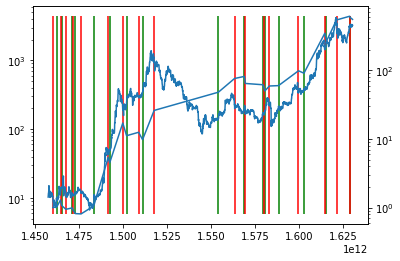

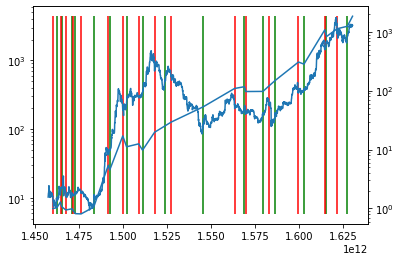

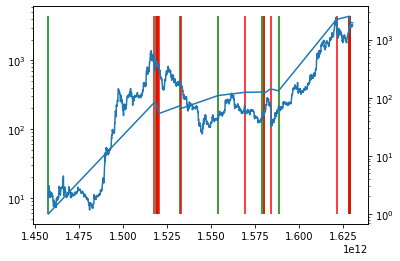

In [53]:
slow=chart.get_sma(weekly_candles,50)
eth_weekly=price.get_price_data('1w', data=eth)
slow_eth=chart.get_sma(eth_weekly,30)
longs, shorts, outcome, profit, final_equity, equity_curve=backtest_ma_channel_single_timeframe(eth, btc_price_data, 7, 20,5)
fig1, ax1= plt.subplots()
ax1.plot(eth['unix'],eth['open'])
#ax1.xlim(1.629*(10**12),1.63*(10**12))
ax1.set_yscale('log')
ax1.vlines(longs, ymin=eth['low'].min(), ymax=eth['high'].max(), colors='green')
ax1.vlines(shorts, ymin=eth['low'].min(), ymax=eth['high'].max(), colors='red')
longs2, shorts2, outcome2, profit2, final_equity2, equity_curve2=backtest_ma_channel_single_timeframe_old(eth, btc_price_data, 7, 20,5)
fig2, ax2= plt.subplots()
ax2.plot(eth['unix'],eth['open'])
#ax1.xlim(1.629*(10**12),1.63*(10**12))
ax2.set_yscale('log')
ax2.vlines(longs2, ymin=eth['low'].min(), ymax=eth['high'].max(), colors='green')
ax2.vlines(shorts2, ymin=eth['low'].min(), ymax=eth['high'].max(), colors='red')
longs3, shorts3, outcome3, profit3, final_equity3, equity_curve3=backtest_eth_through_btc(eth,btc_price_data,20)
fig3, ax3= plt.subplots()
ax3.plot(eth['unix'],eth['open'])
#ax1.xlim(1.639*(10**13),1.63*(10**13))
ax3.set_yscale('log')
ax3.vlines(longs3, ymin=eth['low'].min(), ymax=eth['high'].max(), colors='green')
ax3.vlines(shorts3, ymin=eth['low'].min(), ymax=eth['high'].max(), colors='red')
ax4=ax1.twinx()
ax4.set_yscale('log')
ax5=ax2.twinx()
ax5.set_yscale('log')
ax6=ax3.twinx()
ax6.set_yscale('log')
ax4.plot(equity_curve[:,0],equity_curve[:,1])
ax5.plot(equity_curve2[:,0],equity_curve2[:,1])
ax6.plot(equity_curve3[:,0],equity_curve3[:,1])
print(final_equity,final_equity2, final_equity3)


In [ ]:
def conditional_risk(data,ma_period):
    #identify probability of uptrend and downtrend on moving average
    ma=get_ema()
    #identify P(risk_metric,trend)=P(trend|risk_metric)*P(risk_metric)

    #Risk=P(risk_metric|trend)=P(risk_metric,trend)/P(trend)
    pass

In [ ]:
ethbtc=process_coincodex_csv('ETHBTC_d.csv')
risk=chart.risk_indicator(ethbtc,get_sma(ethbtc,350))
fig1,ax1 = plt.subplots()
ax1.plot(risk['unix'],risk['value'])

In [ ]:
def update_csv(symbol,timeframe):
    
    split_symbol=symbol.split('/')
    base_currency=split_symbol[0]
    quote_currency=split_symbol[1]
    filename=base_currency+quote_currency+'_'+timeframe+'.csv'
    old_data=pd.read_csv('data/'+filename)
    print(old_data)
    max_timestamp=old_data['unix'].max()

    latest_price_data=price.get_price_data(symbol,interval,since=max_timestamp)

    new_data=latest_price_data[latest_price_data['unix']>=max_timestamp]
    old_data.drop(old_data['unix'].idxmax())

    new_file=old_data.append(new_data,ignore_index=True)

    print(new_file)






In [ ]:
recent_eth_minute=price.get_price_data('1m', symbol='ETH-PERP')
channel=chart.h_l_channel(recent_eth_minute,30)
print(channel.iloc[-1])
#channel=channel.iloc[1100:]
plt.plot(recent_eth_minute['unix'], recent_eth_minute['open'])
plt.plot(channel['unix'], channel['high'])
plt.plot(channel['unix'], channel['low'])
high_diff=chart.get_differences(channel['unix'],channel['high'])
low_diff=chart.get_differences(channel['unix'],channel['low'])
high_diff=high_diff.loc[high_diff>0]
low_diff=low_diff.loc[low_diff<0]

In [ ]:
times=high_diff.index
corresponding_opens=[]
for i in range(len(recent_eth_minute['unix'])):
    if recent_eth_minute['unix'].iloc[i] in times:
        current_open=recent_eth_minute['open'].iloc[i]
        corresponding_opens.append(current_open)
corresponding_opens=np.array(corresponding_opens)
difference_metric_series=high_diff.abs()/corresponding_opens
mean=difference_metric_series.mean()
std=difference_metric_series.std()
normalised=(difference_metric_series-mean)/std
indicator=norm.cdf(normalised)
indicator=pd.Series(index=difference_metric_series.index, data=indicator)
tp_times=indicator.loc[indicator>=0.85].index.values
plt.plot(recent_eth_minute['unix'], recent_eth_minute['open'])
plt.plot(channel['unix'], channel['high'])
plt.plot(channel['unix'], channel['low'])
plt.vlines(tp_times,ymin=channel['low'].min(),ymax=channel['high'].max(), colors='red')
print(mean)

In [ ]:
recent_eth_hourly=price.get_price_data('1h', symbol='ETH-PERP')
recent_eth_minute=price.get_price_data('1m', symbol='ETH-PERP')
ema=chart.get_ema(recent_eth_hourly,2)
gradient=chart.get_gradient(ema)
ema

In [ ]:
recent_eth_hourly=price.get_price_data('1h', symbol='ETH-PERP')
recent_eth_minute=price.get_price_data('1m', symbol='ETH-PERP')
ma_channel=chart.ma_channel(recent_eth_minute,16)
ma_channel=ma_channel.iloc[-8:]
five_opens=recent_eth_minute.iloc[-8:]['open'].values # uses opens now as opens are confirmed
print(five_opens<ma_channel['low'])
ma_channel['open']=five_opens
print(ma_channel)

Trimmed datapoints:  2014
1966.2076809002428


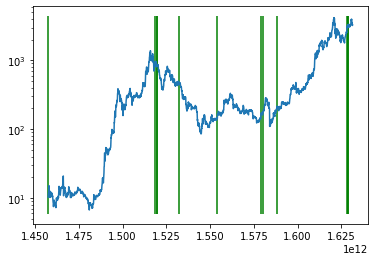

In [ ]:
longs, shorts, outcome, profit, final_equity, equity_curve=backtest_eth_through_btc(eth,btc_price_data,20)
fig1, ax1= plt.subplots()
ax1.plot(eth['unix'],eth['open'])
#ax1.xlim(1.629*(10**12),1.63*(10**12))
ax1.set_yscale('log')
ax1.vlines(longs, ymin=eth['low'].min(), ymax=eth['high'].max(), colors='green')
#ax1.vlines(shorts, ymin=eth['low'].min(), ymax=eth['high'].max(), colors='red')
print(final_equity)